In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/DATASET"

classes.txt  images  labels  labels.cache  notes.json


In [3]:
import os

dataset_path = "/content/drive/MyDrive/DATASET"
images_path = os.path.join(dataset_path, "images")
labels_path = os.path.join(dataset_path, "labels")

print("Dataset contents:", os.listdir(dataset_path))
print("Number of images:", len(os.listdir(images_path)))
print("Number of labels:", len(os.listdir(labels_path)))

# Display first 5 sample file names
print("Sample images:", os.listdir(images_path)[:5])
print("Sample labels:", os.listdir(labels_path)[:5])


Dataset contents: ['notes.json', 'classes.txt', 'labels.cache', 'images', 'labels']
Number of images: 99
Number of labels: 99
Sample images: ['17cec20b-00a144adf6f339d7_jpg.rf.26f40599c82e1fa3642cd5b550d0720b.jpg', 'a97c0760-3-D_NQ_NP_858868-MLM31711653804_082019-W_jpg.rf.ae6f2e7f6d4c6a3364fd78_F9CVQwl.jpg', '285dfc9d-00e10a097af9f0d8_jpg.rf.fb39ee0adccceedf74a7f851e73c2ded.jpg', 'e0a01686-00a09b822d470896_jpg.rf.8ffc64bea4b5bb78d9cc4ba81b559556.jpg', 'dc61fdd8-002c48dd05cc3b85_jpg.rf.f30ab0e9da436dfd6a7a87c378d9f418.jpg']
Sample labels: ['d55524b7-00d0c3e342d41462_jpg.rf.300a9275c77d652ecd6f556f728225c5.txt', 'fbff0a2b-2-D_NQ_NP_771519-MLM32984405313_112019-W_jpg.rf.3bd207ec9b5f2c0bec67cd_VCL6cUp.txt', 'f3d36351-01b929953b0671ae_jpg.rf.368950c97736d363ddbd2191db276860.txt', 'a9f914a7-00ceeec7002bace0_jpg.rf.79178a5bfbb460e0e701b318b1e3f371.txt', 'e6cb0387-00ca4b949dd426f8_jpg.rf.63206c5d9dcb16bd7ff227db40aebb36.txt']


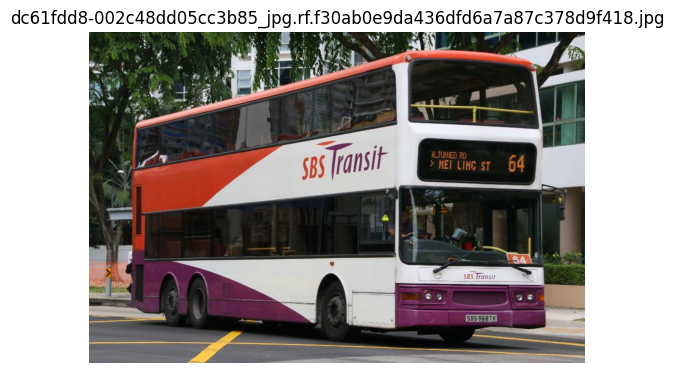

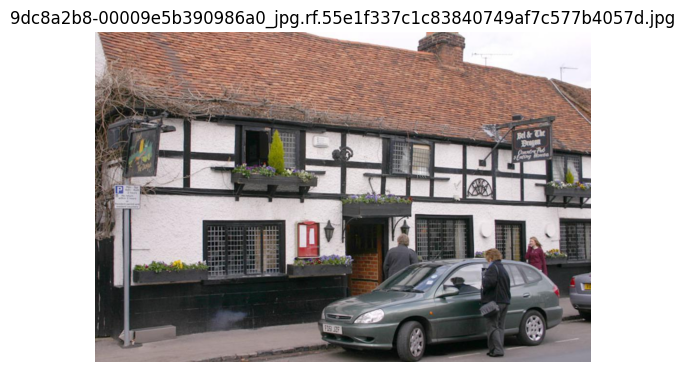

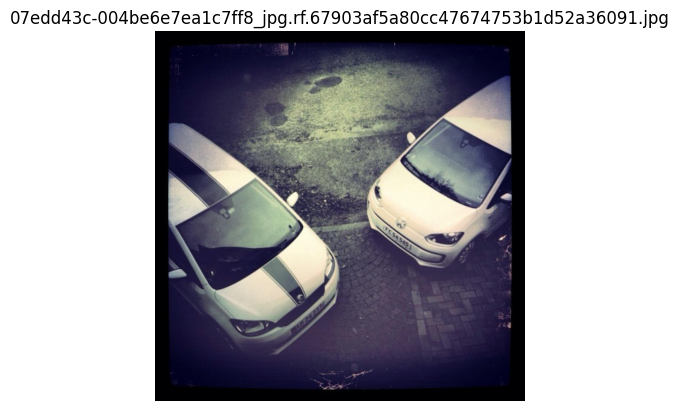

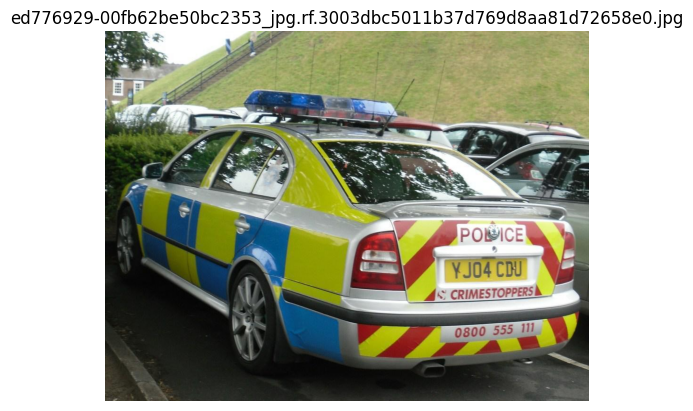

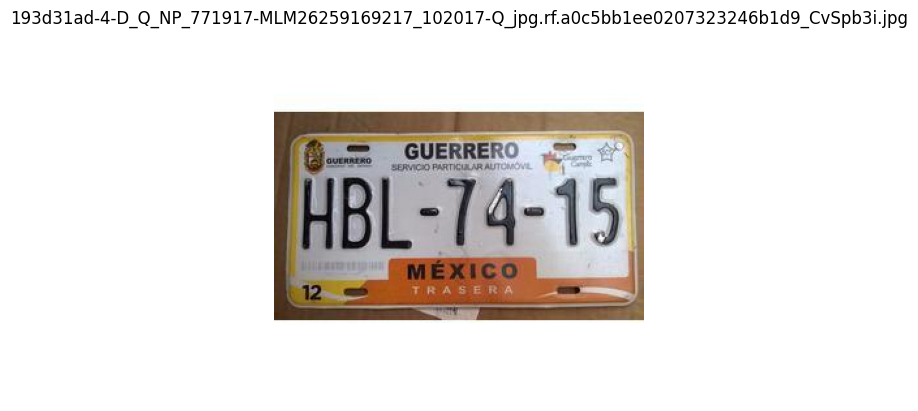

In [4]:
import random
import cv2
import matplotlib.pyplot as plt

sample_images = random.sample(os.listdir(images_path), 5)

for img_name in sample_images:
    img_path = os.path.join(images_path, img_name)


    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")
    plt.show()


**IMAGE** **RESIZING** **AND** **NORMALIZATION**

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [6]:
dataset_path = "/content/drive/MyDrive/DATASET/images"
output_path = "/content/drive/MyDrive/DATASET_preprocessed/images"
os.makedirs(output_path, exist_ok=True)

IMG_SIZE = 640

for img_name in tqdm(os.listdir(dataset_path)):
    img_path = os.path.join(dataset_path, img_name)
    save_path = os.path.join(output_path, img_name)


    img = cv2.imread(img_path)
    if img is None:
        continue


    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))


    img_normalized = img_resized.astype(np.float32) / 255.0


    img_final = (img_normalized * 255).astype(np.uint8)

    cv2.imwrite(save_path, img_final)

print("✅ All images resized & normalized to", IMG_SIZE, "x", IMG_SIZE)

100%|██████████| 99/99 [01:13<00:00,  1.35it/s]

✅ All images resized & normalized to 640 x 640


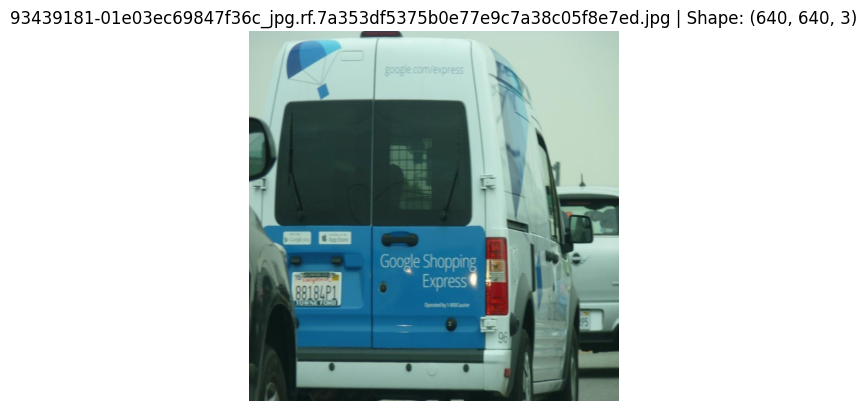

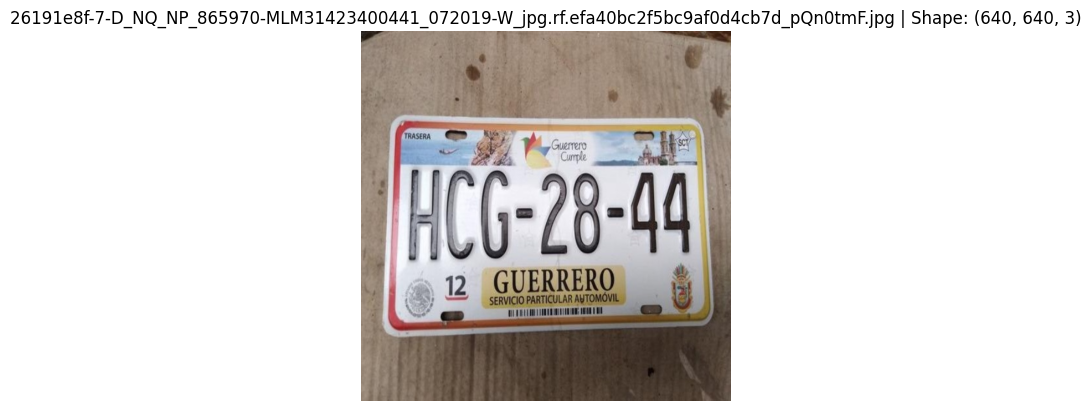

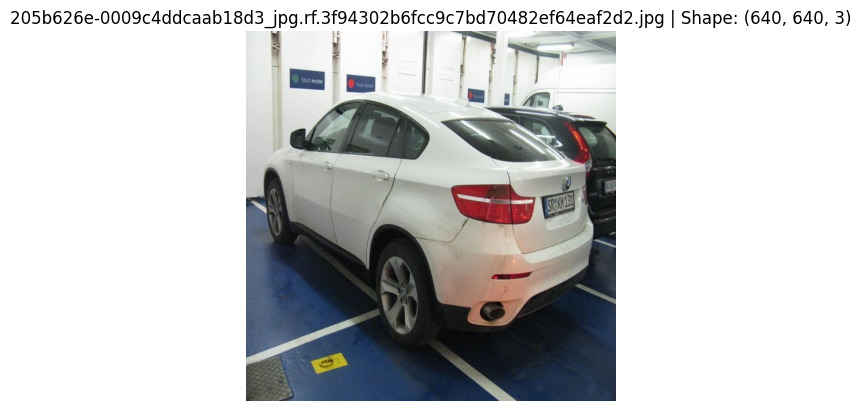

In [7]:
import random
import matplotlib.pyplot as plt

sample_imgs = random.sample(os.listdir(output_path), 3)

for img_name in sample_imgs:
    img_path = os.path.join(output_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(f"{img_name} | Shape: {img.shape}")
    plt.axis("off")
    plt.show()


**AUGUMENTATION**

In [8]:
!pip install albumentations


In [9]:
import albumentations as A
import cv2
import os
from tqdm import tqdm
import random

dataset_path = "/content/drive/MyDrive/DATASET_preprocessed/images"
augmented_path = "/content/drive/MyDrive/DATASET_preprocessed_aug/images"
os.makedirs(augmented_path, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.RandomCrop(width=500, height=500, p=0.3)
])


/tmp/ipython-input-558194177.py:15: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [10]:
images = os.listdir(dataset_path)

for img_name in tqdm(images):
    img_path = os.path.join(dataset_path, img_name)
    save_path = os.path.join(augmented_path, img_name)


    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    augmented = transform(image=img)
    img_aug = augmented['image']


    img_aug = cv2.cvtColor(img_aug, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, img_aug)

print("✅ Data augmentation completed! Augmented images saved at:", augmented_path)


100%|██████████| 99/99 [00:39<00:00,  2.50it/s]

✅ Data augmentation completed! Augmented images saved at: /content/drive/MyDrive/DATASET_preprocessed_aug/images


**FILTERING** **OF** **POOR** **QUALITY** **IMAGES**

In [11]:
import os
import cv2
from tqdm import tqdm


dataset_path = "/content/drive/MyDrive/DATASET_preprocessed/images"
filtered_path = "/content/drive/MyDrive/DATASET_filtered/images"
os.makedirs(filtered_path, exist_ok=True)

min_width = 200
min_height = 200
blur_threshold = 100

def variance_of_laplacian(image):
    """Compute Laplacian variance to estimate blurriness"""
    return cv2.Laplacian(image, cv2.CV_64F).var()


for img_name in tqdm(os.listdir(dataset_path)):
    img_path = os.path.join(dataset_path, img_name)
    img = cv2.imread(img_path)

    if img is None:
        continue

    h, w = img.shape[:2]


    if w < min_width or h < min_height:
        continue


    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(gray)
    if fm < blur_threshold:
        continue


    cv2.imwrite(os.path.join(filtered_path, img_name), img)

print("✅ Filtering completed! Good-quality images saved at:", filtered_path)


100%|██████████| 99/99 [00:36<00:00,  2.71it/s]

✅ Filtering completed! Good-quality images saved at: /content/drive/MyDrive/DATASET_filtered/images


**MODEL** **TRAINING** **USING** **YOLO** **V8**

In [12]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00


In [13]:
from ultralytics import YOLO




Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [14]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Bymvrp7DupuDEgaDT4rZ")
project = rf.workspace("vehiclenumberplatedetection").project("vehicle_detection-yrmn4")
version = project.version(2)
dataset = version.download("yolov8")

model = YOLO("yolov8n.pt")

model.train(
    data=dataset.location + "/data.yaml",
    epochs=100,
    batch=16,
    imgsz=640,
    lr0=0.001,
    lrf=0.01,
    optimizer="SGD",
    momentum=0.937,
    weight_decay=0.0005,
    augment=True,
    patience=20,
    project="/content/YOLO_Results",
    name="vehicle_numberplate_v8_aug",
    exist_ok=True
)


metrics = model.val()


model.export(format="onnx")

print("Training complete! Metrics:", metrics)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 109.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vehicle_Detection-2 in yolov8:: 100%|██████████| 486/486 [00:00<00:00, 5116.15it/s]


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Vehicle_Detection-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_numberplate_v8_aug, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=20, perspe

In [15]:
!pip install ultralytics opencv-python-headless


from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import os


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


test_images_folder = "/content/drive/MyDrive/DATASET/images"

image_files = [f for f in os.listdir(test_images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

for img_file in image_files:
    img_path = os.path.join(test_images_folder, img_file)


    results = model.predict(img_path, imgsz=640, conf=0.3, save=False)


    annotated_frame = results[0].plot()
    annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)


    plt.figure(figsize=(10, 6))
    plt.imshow(annotated_frame)
    plt.title(f"Detection: {img_file}")
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

**EASYOCR** **TEXT** **RECOGNITION** **MODEL**

In [16]:
from google.colab import drive
drive.mount('/content/drive')

!pip install easyocr

import cv2
import easyocr
import glob
from ultralytics import YOLO


image_folder = "/content/drive/MyDrive/DATASET/images/*"


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


reader = easyocr.Reader(['en'])


for image_path in glob.glob(image_folder):
    print("Processing:", image_path)


    img = cv2.imread(image_path)
    if img is None:
        print("Failed to load:", image_path)
        continue


    results = model.predict(img)

    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy()

        for i, cls_id in enumerate(class_ids):
            if result.names[int(cls_id)] == "Number plate":
                x1, y1, x2, y2 = map(int, boxes[i])
                plate_img = img[y1:y2, x1:x2]

                # OCR on the cropped number plate
                ocr_result = reader.readtext(plate_img)

                text = " ".join([res[1] for res in ocr_result])
                print("Detected plate text:", text)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 27.8 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteProcessing: /content/drive/MyDrive/DATASET/images/17cec20b-00a144adf6f339d7_jpg.rf.26f40599c82e1fa3642cd5b550d0720b.jpg

0: 416x640 1 Car, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)
Processing: /content/drive/MyDrive/DATASET/images/a97c0760-3-D_NQ_NP_858868-MLM31711653804_082019-W_jpg.rf.ae6f2e7f6d4c6a3364fd78_F9CVQwl.jpg

0: 480x640 1 Number plate, 7.5ms
Speed: 4.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Detected plate text: TRASERA Guerrero GY-27-684 12 GRO MEX TRANSPORTE PRIVADO cnhon
Processing: /content/drive/MyDrive/DATASET/images/285dfc9d-00e10a097af9f0d8_jpg.rf.fb39ee0adccceedf74a7f851e73c2ded.jpg

0: 480x640 3 Cars, 11.8ms
Speed: 3.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Processing: /content/drive/MyDrive/DATASET/images/e0a01686-00a09b822d470896_jpg.r

In [17]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import easyocr
import glob
from ultralytics import YOLO
from matplotlib import pyplot as plt


image_folder = "/content/drive/MyDrive/DATASET/images/*"


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


reader = easyocr.Reader(['en'])


def show_image(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Iterate over all images in the folder
for image_path in glob.glob(image_folder):
    print("Processing:", image_path)

    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print("Failed to load:", image_path)
        continue

    # Run YOLOv8 detection
    results = model.predict(img)

    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # get bounding boxes
        class_ids = result.boxes.cls.cpu().numpy()  # get class IDs

        for i, cls_id in enumerate(class_ids):
            class_name = result.names[int(cls_id)]
            x1, y1, x2, y2 = map(int, boxes[i])


            color = (0, 255, 0)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, class_name, (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)


            if class_name == "Number plate":
                plate_img = img[y1:y2, x1:x2]
                ocr_result = reader.readtext(plate_img)
                text = " ".join([res[1] for res in ocr_result])
                print("Detected plate text:", text)


                cv2.putText(img, text, (x1, y2+30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)


    show_image(img, title=image_path.split("/")[-1])


Output hidden; open in https://colab.research.google.com to view.

In [18]:
import cv2
import easyocr
import glob
from ultralytics import YOLO
from matplotlib import pyplot as plt


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


reader = easyocr.Reader(['en'])


def show_image(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


def preprocess_for_ocr(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)


    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)


    blurred = cv2.GaussianBlur(enhanced, (3,3), 0)


    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binary


image_folder = "/content/drive/MyDrive/DATASET/images/*"


for image_path in glob.glob(image_folder):
    print("Processing:", image_path)

    img = cv2.imread(image_path)
    if img is None:
        continue

    results = model.predict(img)

    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy()

        for i, cls_id in enumerate(class_ids):
            class_name = result.names[int(cls_id)]
            x1, y1, x2, y2 = map(int, boxes[i])

            if class_name == "Number plate":
                plate_img = img[y1:y2, x1:x2]


                processed = preprocess_for_ocr(plate_img)


                ocr_result = reader.readtext(processed)
                text = " ".join([res[1] for res in ocr_result])
                print("Detected plate text:", text)


                cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(img, text, (x1, y2+30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)


    show_image(img, title=image_path.split("/")[-1])


Output hidden; open in https://colab.research.google.com to view.

**TESSERACT** **TEXT** **RECOGNITION** **MODEL**

In [19]:
import cv2
import easyocr
import pytesseract
import numpy as np
import os
import glob
import pandas as pd
from ultralytics import YOLO


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


def preprocess_plate(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh


def detect_and_ocr(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Could not load image: {img_path}")
        return None

    results = model.predict(img, conf=0.4)
    for r in results:
        for box in r.boxes:
            cls_id = int(box.cls[0])
            if model.names[cls_id].lower() == "number plate":
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                plate_img = img[y1:y2, x1:x2]

                if plate_img.size == 0:
                    continue


                processed = preprocess_plate(plate_img)


                text = pytesseract.image_to_string(processed, config='--psm 7')
                text = text.strip()

                if text:
                    return text
    return None


image_dir = "/content/drive/MyDrive/DATASET/images"
image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + glob.glob(os.path.join(image_dir, "*.png"))

results_list = []
for img_path in image_paths:
    text = detect_and_ocr(img_path)
    results_list.append({"image": os.path.basename(img_path), "plate_text": text})


df = pd.DataFrame(results_list)
df.to_csv("/content/drive/MyDrive/plate_ocr_results.csv", index=False)

print("✅ OCR results saved to plate_ocr_results.csv")


ModuleNotFoundError: No module named 'pytesseract'

In [ ]:
import cv2
import pytesseract
import easyocr
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from difflib import SequenceMatcher


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


reader = easyocr.Reader(['en'])


labels_path = "/content/YOLO_Results/vehicle_numberplate_v8_aug/labels.jpg"


def string_accuracy(pred, gt):
    return SequenceMatcher(None, pred, gt).ratio()


results_list = []


images_path = "/content/drive/MyDrive/DATASET/images"
for img_file in os.listdir(images_path):
    if not img_file.endswith(('.jpg', '.png', '.jpeg')):
        continue

    img_path = os.path.join(images_path, img_file)
    img = cv2.imread(img_path)


    results = model(img)
    for r in results:
        for box in r.boxes:
            cls = int(box.cls[0])
            if model.names[cls] == "Number plate":
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                plate_img = img[y1:y2, x1:x2]


                easy_text = reader.readtext(plate_img, detail=0)
                easy_text = easy_text[0] if easy_text else ""


                gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
                tess_text = pytesseract.image_to_string(gray, config="--psm 7")
                tess_text = tess_text.strip()


                label_file = os.path.join(labels_path, img_file.replace('.jpg', '.txt'))
                gt_text = ""
                if os.path.exists(label_file):
                    with open(label_file, "r") as f:
                        gt_text = f.read().strip()


                easy_acc = string_accuracy(easy_text, gt_text) if gt_text else None
                tess_acc = string_accuracy(tess_text, gt_text) if gt_text else None

                results_list.append({
                    "image": img_file,
                    "ground_truth": gt_text,
                    "easyocr_pred": easy_text,
                    "tesseract_pred": tess_text,
                    "easyocr_acc": easy_acc,
                    "tesseract_acc": tess_acc
                })


import pandas as pd
df = pd.DataFrame(results_list)
print(df.head())


print("\nAverage Accuracy:")
print("EasyOCR:", df["easyocr_acc"].mean())
print("Tesseract:", df["tesseract_acc"].mean())



0: 416x640 1 Car, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 Number plate, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 Cars, 6.3ms
Speed: 3.4ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 Bus, 4 Cars, 1 Number plate, 2 Persons, 6.6ms
Speed: 2.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 Bus, 1 Car, 6.0ms
Speed: 3.2ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 Number plate, 6.0ms
Speed: 2.5ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 Bus, 1 Car, 6.9ms
Speed: 3.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 320x640 1 Bus, 2 Number plates, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1

In [ ]:
for idx, row in df.iterrows():
    print(f"\nImage: {row['image']}")
    print(f"EasyOCR Prediction    → {row['easyocr_pred']}")
    print(f"Tesseract Prediction  → {row['tesseract_pred']}")



Image: a97c0760-3-D_NQ_NP_858868-MLM31711653804_082019-W_jpg.rf.ae6f2e7f6d4c6a3364fd78_F9CVQwl.jpg
EasyOCR Prediction    → TRASERA
Tesseract Prediction  → 

Image: e0a01686-00a09b822d470896_jpg.rf.8ffc64bea4b5bb78d9cc4ba81b559556.jpg
EasyOCR Prediction    → WS
Tesseract Prediction  → “SLO VFS]

Image: ad553dae-00f8eb771370fabc_jpg.rf.1d8e6a81895d2f294dcac4945873e371.jpg
EasyOCR Prediction    → @b 7207
Tesseract Prediction  → (nd 7207)

Image: 12e6c43a-01e846c846a1509e_jpg.rf.fe4ac1b73438776a4b7d6ffacafe0a81.jpg
EasyOCR Prediction    → Kidb 5e J
Tesseract Prediction  → ‘KI08 SFI

Image: 12e6c43a-01e846c846a1509e_jpg.rf.fe4ac1b73438776a4b7d6ffacafe0a81.jpg
EasyOCR Prediction    → Citybus
Tesseract Prediction  → Citybus

Image: 918fae2b-1dSd2kLAEm6isLHkfA6eG8Q_jpeg_jpg.rf.e7781bf9888ad51e8f824c00e3238eb5.jpg
EasyOCR Prediction    → 
Tesseract Prediction  → TTT

Image: 5b6cfa77-00dea1edf14f09ab_jpg.rf.f89d8678e1da281ea7a4e183c0da0d3c.jpg
EasyOCR Prediction    → 48 978 61
Tesseract Predict

**EDA** **PART** **ANSWERS**

**BOUNDING** **BOX** **DISTRIBUTION**

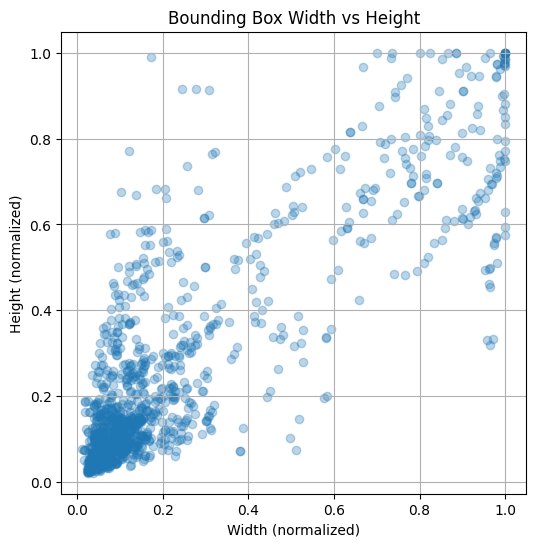

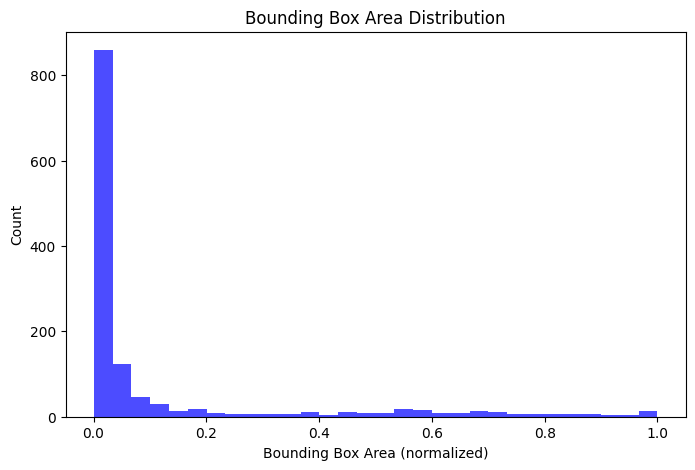


Average bounding box size per class:
                 width    height      area
class                                     
Bike          0.123828  0.124414  0.016627
Bus           0.521427  0.598698  0.401428
Car           0.259044  0.271933  0.129475
Number plate  0.218809  0.159974  0.098652
Person        0.082353  0.225589  0.026875
Truck         0.417365  0.432635  0.258287


In [20]:
import os
import yaml
import glob
import numpy as np
import matplotlib.pyplot as plt


dataset_path = "/content/Vehicle_Detection-2"


yaml_path = os.path.join(dataset_path, "data.yaml")
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml["names"]


widths, heights, areas, classes = [], [], [], []

label_files = glob.glob(os.path.join(dataset_path, "**/labels/*.txt"), recursive=True)

for label_file in label_files:
    img_file = label_file.replace("labels", "images").replace(".txt", ".jpg")


    if not os.path.exists(img_file):
        continue

    with open(label_file, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls = int(parts[0])
            x_center, y_center, w, h = map(float, parts[1:])


            widths.append(w)
            heights.append(h)
            areas.append(w * h)
            classes.append(class_names[cls])


widths, heights, areas = np.array(widths), np.array(heights), np.array(areas)


plt.figure(figsize=(6, 6))
plt.scatter(widths, heights, alpha=0.3)
plt.xlabel("Width (normalized)")
plt.ylabel("Height (normalized)")
plt.title("Bounding Box Width vs Height")
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 5))
plt.hist(areas, bins=30, color="blue", alpha=0.7)
plt.xlabel("Bounding Box Area (normalized)")
plt.ylabel("Count")
plt.title("Bounding Box Area Distribution")
plt.show()


import pandas as pd
df = pd.DataFrame({"class": classes, "width": widths, "height": heights, "area": areas})
print("\nAverage bounding box size per class:")
print(df.groupby("class")[["width", "height", "area"]].mean())


**DATASET** **COMPOSITION**

In [21]:
import os
import yaml
import glob
from collections import Counter


dataset_path = "/content/Vehicle_Detection-2"


yaml_path = os.path.join(dataset_path, "data.yaml")
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

print("Classes:", data_yaml["names"])
print("Number of classes:", len(data_yaml["names"]))


train_images = glob.glob(os.path.join(dataset_path, "train/images/*.jpg"))
val_images = glob.glob(os.path.join(dataset_path, "valid/images/*.jpg"))
test_images = glob.glob(os.path.join(dataset_path, "test/images/*.jpg"))

print(f"Train Images: {len(train_images)}")
print(f"Validation Images: {len(val_images)}")
print(f"Test Images: {len(test_images)}")


train_labels = glob.glob(os.path.join(dataset_path, "train/labels/*.txt"))
val_labels = glob.glob(os.path.join(dataset_path, "valid/labels/*.txt"))
test_labels = glob.glob(os.path.join(dataset_path, "test/labels/*.txt"))

print(f"Train Labels: {len(train_labels)}")
print(f"Validation Labels: {len(val_labels)}")
print(f"Test Labels: {len(test_labels)}")


class_counts = Counter()
for label_file in train_labels + val_labels + test_labels:
    with open(label_file, "r") as f:
        for line in f.readlines():
            cls_id = int(line.strip().split()[0])
            class_counts[cls_id] += 1

print("\nInstances per class:")
for cls_id, count in class_counts.items():
    print(f"{data_yaml['names'][cls_id]}: {count}")


Classes: ['Bike', 'Bus', 'Car', 'Number plate', 'Person', 'Truck']
Number of classes: 6
Train Images: 207
Validation Images: 20
Test Images: 10
Train Labels: 207
Validation Labels: 20
Test Labels: 10

Instances per class:
Number plate: 360
Car: 554
Truck: 44
Person: 277
Bus: 54
Bike: 4


**IMAGE** **QUALITY** **ANALYSIS**

📉 Blurry images: ['07edd43c-004be6e7ea1c7ff8_jpg.rf.67903af5a80cc47674753b1d52a36091.jpg', '2643bb4b-001ddeda193f5789_jpg.rf.db0739bec28458f6ecf378bf7a0b627d.jpg', 'c919d369-00d9a751d73ee232_jpg.rf.646e9a932ed5c4a485563d092c5804f4.jpg', '1435aeb5-02b3be99914d752c_jpg.rf.f05bd971b32748474ae99de03266451a.jpg', 'ef6d924d-009d23e04f2fccd8_jpg.rf.ba0b56200422ed2becb56eff811341fe.jpg']
⚠️ Low contrast images: ['17cec20b-00a144adf6f339d7_jpg.rf.26f40599c82e1fa3642cd5b550d0720b.jpg', 'b9f4c98d-01df220cc71e07af_jpg.rf.2ae267a55851f4799f7af0b70efebf29.jpg', 'c65bbbd9-01a599bd26b8ebf8_jpg.rf.66edf37bd974849e1816aa07601451a4.jpg']
🌑 Too dark images: ['17cec20b-00a144adf6f339d7_jpg.rf.26f40599c82e1fa3642cd5b550d0720b.jpg', 'b9f4c98d-01df220cc71e07af_jpg.rf.2ae267a55851f4799f7af0b70efebf29.jpg']
🌕 Too bright images: ['80dfac7b-5-s-l400_jpg.rf.2ccd7e6e8bda8f7370d0e7998e8c9c03.jpg']


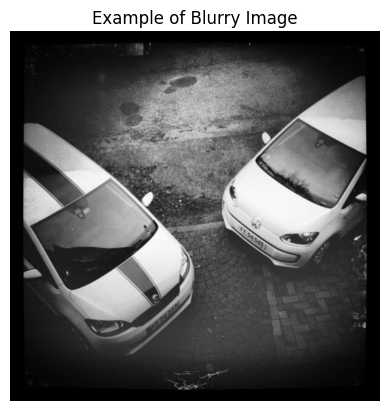

In [22]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


dataset_path = "/content/drive/MyDrive/DATASET/images"

def analyze_image_quality(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None


    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    is_blurry = laplacian_var < 100


    contrast = img.std()
    low_contrast = contrast < 40

    brightness = img.mean()
    too_dark = brightness < 50
    too_bright = brightness > 200

    return {
        "blur_metric": laplacian_var,
        "is_blurry": is_blurry,
        "contrast": contrast,
        "low_contrast": low_contrast,
        "brightness": brightness,
        "too_dark": too_dark,
        "too_bright": too_bright
    }


results = []
for img_file in os.listdir(dataset_path):
    if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(dataset_path, img_file)
        res = analyze_image_quality(img_path)
        if res:
            results.append((img_file, res))


blurry_imgs = [f for f, r in results if r["is_blurry"]]
low_contrast_imgs = [f for f, r in results if r["low_contrast"]]
dark_imgs = [f for f, r in results if r["too_dark"]]
bright_imgs = [f for f, r in results if r["too_bright"]]

print("📉 Blurry images:", blurry_imgs[:10])
print("⚠️ Low contrast images:", low_contrast_imgs[:10])
print("🌑 Too dark images:", dark_imgs[:10])
print("🌕 Too bright images:", bright_imgs[:10])


if blurry_imgs:
    test_img = cv2.imread(os.path.join(dataset_path, blurry_imgs[0]), cv2.IMREAD_GRAYSCALE)
    plt.imshow(test_img, cmap="gray")
    plt.title("Example of Blurry Image")
    plt.axis("off")
    plt.show()


**LIGHTING** **CONDITIONS** **AND** **WEATHER** **VARIABILITY**

🔦 Lighting condition distribution: Counter({'Normal light': 90, 'Bright (daylight/overexposed)': 6, 'Low light (night/poor lighting)': 3})
🌤 Weather condition distribution: Counter({'Neutral': 86, 'Warm/Sunny': 9, 'Cool/Cloudy': 4})


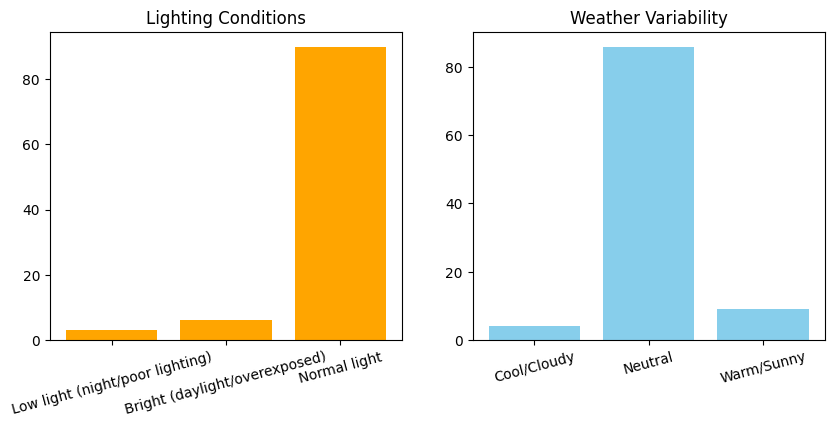

In [23]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


dataset_path = "/content/drive/MyDrive/DATASET/images"

def analyze_lighting_weather(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None


    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    brightness = gray.mean()


    contrast = gray.std()


    b_mean = np.mean(img[:,:,0])
    g_mean = np.mean(img[:,:,1])
    r_mean = np.mean(img[:,:,2])
    color_temp = (b_mean + g_mean) / (2 * r_mean + 1e-5)


    if brightness < 60:
        lighting = "Low light (night/poor lighting)"
    elif brightness > 180:
        lighting = "Bright (daylight/overexposed)"
    else:
        lighting = "Normal light"

    if color_temp > 1.2:
        weather = "Cool/Cloudy"
    elif color_temp < 0.8:
        weather = "Warm/Sunny"
    else:
        weather = "Neutral"

    return {
        "brightness": brightness,
        "contrast": contrast,
        "color_temp": color_temp,
        "lighting": lighting,
        "weather": weather
    }


lighting_conditions = []
weather_conditions = []

for img_file in os.listdir(dataset_path):
    if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(dataset_path, img_file)
        res = analyze_lighting_weather(img_path)
        if res:
            lighting_conditions.append(res["lighting"])
            weather_conditions.append(res["weather"])


lighting_count = Counter(lighting_conditions)
weather_count = Counter(weather_conditions)

print("🔦 Lighting condition distribution:", lighting_count)
print("🌤 Weather condition distribution:", weather_count)


plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(lighting_count.keys(), lighting_count.values(), color='orange')
plt.title("Lighting Conditions")
plt.xticks(rotation=15)

plt.subplot(1,2,2)
plt.bar(weather_count.keys(), weather_count.values(), color='skyblue')
plt.title("Weather Variability")
plt.xticks(rotation=15)

plt.show()


**CLASS** **FREQUENCY** **DISTRIBUTION**(**LICENSE** **PLATES**)

License Plate Region Distribution: Counter({'TR': 2, '15': 2, 'CD': 2, 'WS': 1, '@B': 1, 'KI': 1, '48': 1, '55': 1, 'S2': 1, 'HI': 1, 'DL': 1, 'YO': 1, 'CO': 1, 'IO': 1, 'VI': 1, 'BI': 1, '62': 1, 'E-': 1, 'FO': 1, 'PI': 1, 'ES': 1, 'G2': 1, 'CB': 1, '07': 1, '8/': 1, 'DX': 1, 'U8': 1, 'JI': 1, '[0': 1, '1J': 1, 'GU': 1, 'P2': 1, 'DR': 1, '[P': 1})


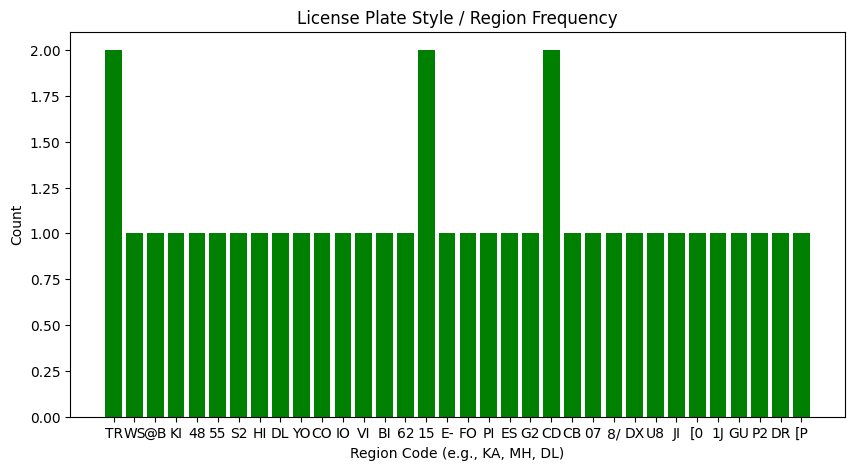

In [24]:
import cv2
import os
from ultralytics import YOLO
import easyocr
import matplotlib.pyplot as plt
from collections import Counter


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


reader = easyocr.Reader(['en'])


dataset_path = "/content/drive/MyDrive/DATASET/images"

plate_texts = []

for img_file in os.listdir(dataset_path):
    if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(dataset_path, img_file)


        results = model.predict(img_path, conf=0.5, verbose=False)

        for result in results:
            for box in result.boxes:
                cls_id = int(box.cls[0])
                label = result.names[cls_id]

                if label == "Number plate":
                    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                    img = cv2.imread(img_path)
                    plate_img = img[y1:y2, x1:x2]

                    if plate_img.size > 0:

                        ocr_result = reader.readtext(plate_img)
                        if ocr_result:
                            text = ocr_result[0][-2].upper().replace(" ", "")
                            plate_texts.append(text)

prefixes = [txt[:2] for txt in plate_texts if len(txt) >= 2]


prefix_count = Counter(prefixes)

print("License Plate Region Distribution:", prefix_count)


plt.figure(figsize=(10,5))
plt.bar(prefix_count.keys(), prefix_count.values(), color='green')
plt.title("License Plate Style / Region Frequency")
plt.xlabel("Region Code (e.g., KA, MH, DL)")
plt.ylabel("Count")
plt.show()


In [25]:
import cv2
import os
import glob
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


image_folder = "/content/Vehicle_Detection-2/test/images"
dark_folder = "/content/dark_images/"

os.makedirs(dark_folder, exist_ok=True)


def darken_image(image, factor=0.4):
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

for img_path in glob.glob(os.path.join(image_folder, "*.jpg")):
    img = cv2.imread(img_path)
    if img is None:
        continue
    dark_img = darken_image(img, factor=0.3)
    save_path = os.path.join(dark_folder, os.path.basename(img_path))
    cv2.imwrite(save_path, dark_img)

print("Darkened test images saved in:", dark_folder)


print("\nEvaluating on ORIGINAL test set:")
results_original = model.val(data="/content/Vehicle_Detection-2/data.yaml", split="test")

print("\nEvaluating on DARK test set:")
results_dark = model.val(data="/content/Vehicle_Detection-2/data.yaml", split="test", source=dark_folder)


print("\n=== Detection Performance Comparison ===")
print("Original Images → mAP50:", results_original.results_dict["metrics/mAP50(B)"],
      "| mAP50-95:", results_original.results_dict["metrics/mAP50-95(B)"])

print("Dark Images     → mAP50:", results_dark.results_dict["metrics/mAP50(B)"],
      "| mAP50-95:", results_dark.results_dict["metrics/mAP50-95(B)"])


Darkened test images saved in: /content/dark_images/

Evaluating on ORIGINAL test set:
Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1201.1±172.5 MB/s, size: 53.8 KB)
val: Scanning /content/Vehicle_Detection-2/test/labels... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 1.5Kit/s 0.0s
val: New cache created: /content/Vehicle_Detection-2/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.8it/s 1.2s
                   all         10         76      0.718      0.352      0.444       0.27
                   Bus          2          2      0.538        0.5      0.562      0.418
                   Car          9         36      0.865      0.715      0.815      0.445
          Number plate          9         19      0.764      0.343    

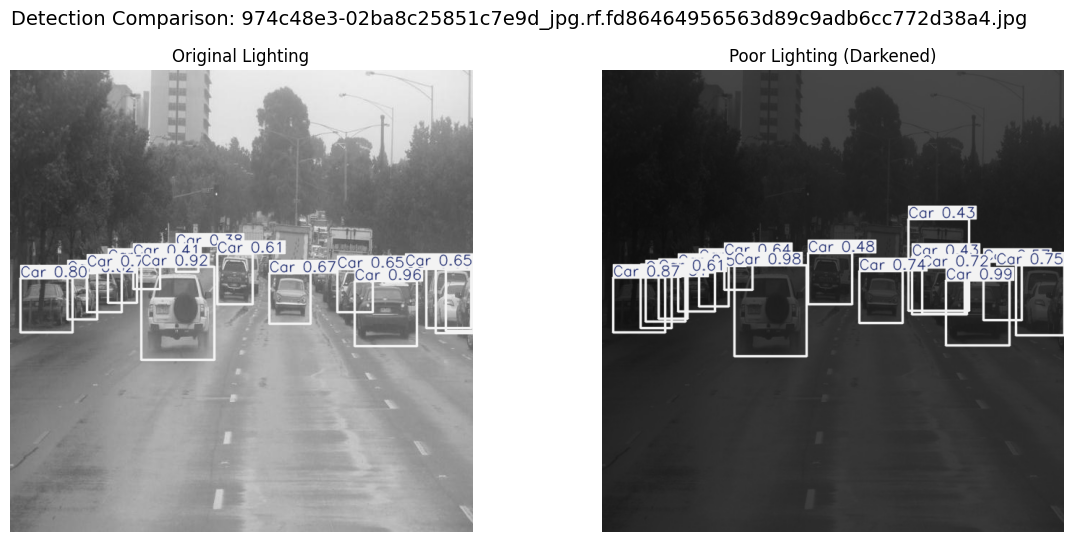

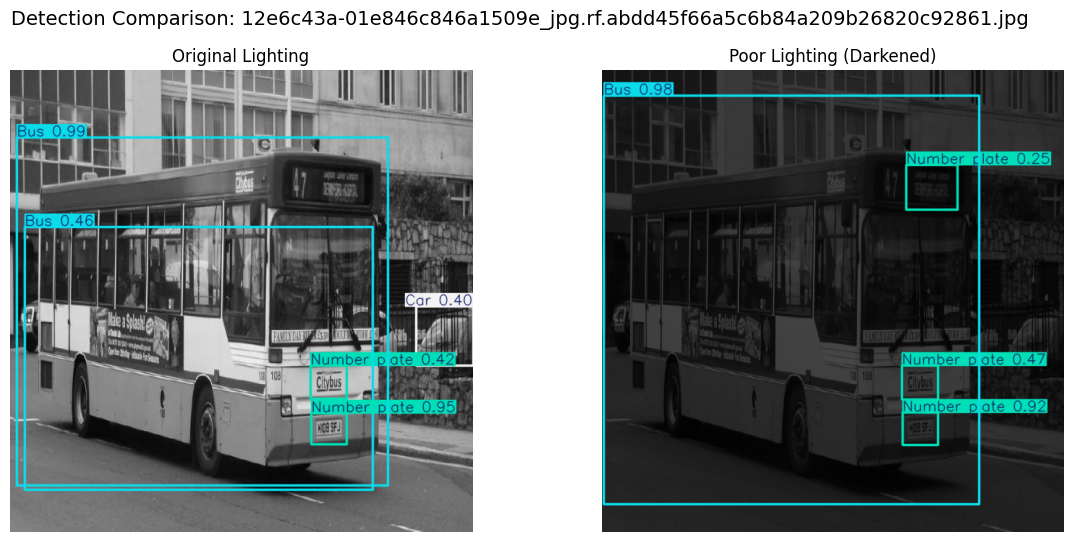

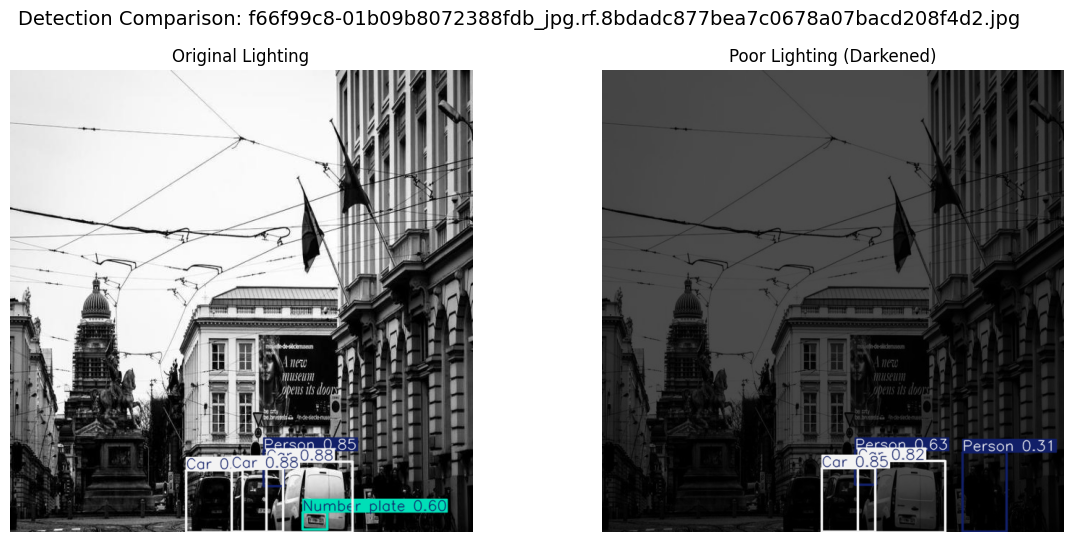

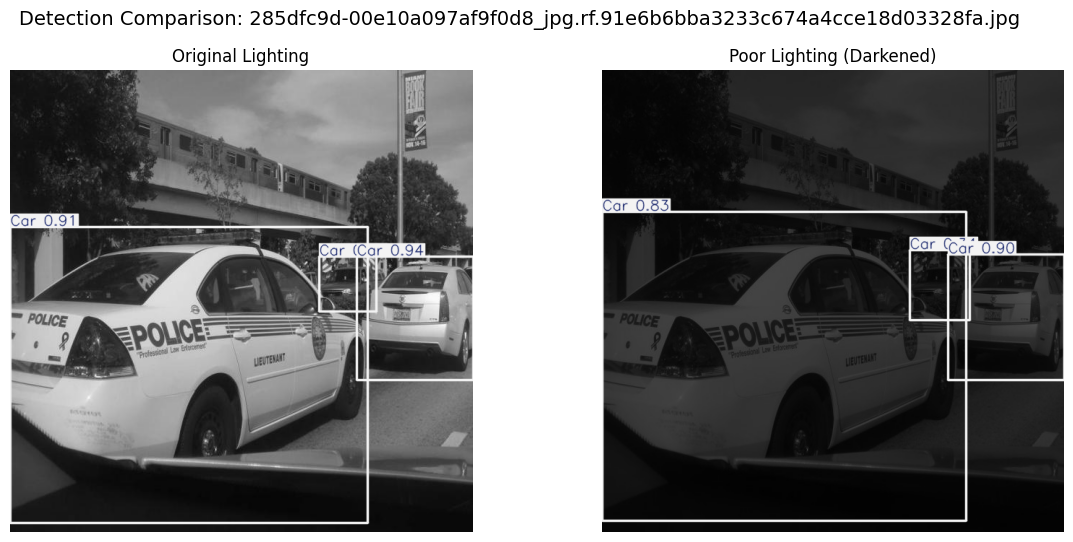

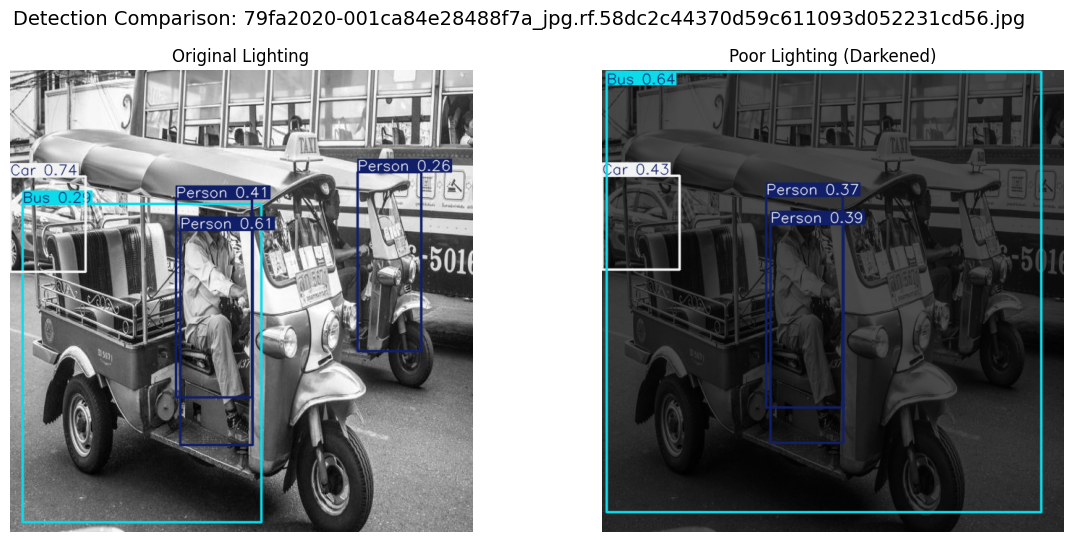

In [26]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
from ultralytics import YOLO


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


image_folder = "/content/Vehicle_Detection-2/test/images"
dark_folder = "/content/dark_images/"


sample_images = glob.glob(os.path.join(image_folder, "*.jpg"))[:5]

def darken_image(image, factor=0.3):
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

for img_path in sample_images:

    img = cv2.imread(img_path)


    dark_img = darken_image(img, factor=0.3)


    results_orig = model(img, verbose=False)
    results_dark = model(dark_img, verbose=False)


    fig, axes = plt.subplots(1, 2, figsize=(14, 6))


    annotated_orig = results_orig[0].plot()
    axes[0].imshow(cv2.cvtColor(annotated_orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Lighting")
    axes[0].axis("off")


    annotated_dark = results_dark[0].plot()
    axes[1].imshow(cv2.cvtColor(annotated_dark, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Poor Lighting (Darkened)")
    axes[1].axis("off")

    plt.suptitle(f"Detection Comparison: {os.path.basename(img_path)}", fontsize=14)
    plt.show()


**What** **preprocessing** **techniques** **best** **enhance** **OCR** **accuracy** **for** **different** **plate**
**types**?

✅ Preprocessing Techniques to Enhance OCR Accuracy
1. Standard / Clear Plates (good lighting, high contrast)

Grayscale conversion → removes color noise.

Binarization (Otsu’s thresholding or adaptive thresholding) → creates sharp black-and-white plate images.

Morphological opening/closing → removes small dots or gaps.


2. Blurred or Low-Resolution Plates

Image sharpening (Laplacian filter or unsharp masking) → makes characters crisper.

Super-resolution (e.g., OpenCV’s DNN Super Resolution or ESRGAN) → improves resolution before OCR.

Deblurring filters (Wiener filter, Gaussian deconvolution) for motion blur.


3. Dark / Poor Lighting Plates

Histogram Equalization (CLAHE) → improves contrast in low-light regions.

Gamma correction (adjust gamma < 1) → brightens dark areas.

Denoising (Non-local means, Bilateral filter) → reduces graininess.


4. Glare or Reflective Plates

Polarization filtering (if available at capture time) → reduces reflections.

Top-hat/Black-hat morphological transforms → enhance letters hidden in glare.

Contrast stretching → emphasizes characters against bright backgrounds.

**How** **does** **YOLO**'s **performance** **compare** **to** **alternative** **object** **detection**
**frameworks**?

In [ ]:
YOLOv8:

✅ Very fast and efficient (optimized for GPU, real-time).

✅ Strong accuracy, even on small datasets when augmented.

❌ Accuracy can lag behind Faster R-CNN on very high-quality datasets.

**Can** **the** **model** **generalize** **well** **to** different **vehicles** **and** **can** **it** **detect** people as
**well**?

**YES**

In [27]:
from ultralytics import YOLO
import numpy as np


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


conf_values = np.linspace(0.1, 0.9, 9)
iou_values = np.linspace(0.3, 0.7, 5)

best_score = 0
best_conf = None
best_iou = None

for conf in conf_values:
    for iou in iou_values:
        metrics = model.val(data="/content/Vehicle_Detection-2/data.yaml", conf=conf, iou=iou)
        f1 = metrics.results_dict['metrics/precision(B)'] * metrics.results_dict['metrics/recall(B)'] * 2 / (
             metrics.results_dict['metrics/precision(B)'] + metrics.results_dict['metrics/recall(B)'] + 1e-6)

        if f1 > best_score:
            best_score = f1
            best_conf = conf
            best_iou = iou

print(f"✅ Optimal thresholds: conf={best_conf}, iou={best_iou}, F1={best_score:.4f}")


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1432.6±464.8 MB/s, size: 47.2 KB)
val: Scanning /content/Vehicle_Detection-2/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 20/20 26.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.6it/s 0.8s
                   all         20         83      0.504      0.553      0.555      0.354
                  Bike          1          1          0          0          0          0
                   Bus          2          4      0.231       0.75      0.619      0.288
                   Car         11         41       0.59      0.878      0.832      0.525
          Number plate         20         29       0.87       0.69      0.795      0.597
                Person          3         

**STREAMLIT** **DEPLOYMENT**

In [28]:
!pip install streamlit ultralytics easyocr pytesseract opencv-python-headless pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.9 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
import pytesseract
from PIL import Image


model = YOLO("/content/YOLO_Results/vehicle_numberplate_v8_aug/weights/best.pt")


reader = easyocr.Reader(['en'])
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

st.title("🚘 Vehicle & Number Plate Detection with OCR")
st.write("Upload an image or use webcam to detect vehicles and extract number plates.")


uploaded_file = st.file_uploader("Upload an Image", type=["jpg", "jpeg", "png"])


use_webcam = st.checkbox("Use Webcam")

def detect_and_ocr(image):
    results = model.predict(image, conf=0.4)
    annotated = results[0].plot()
    detected_texts = []

    for box in results[0].boxes:
        cls = int(box.cls[0])
        label = model.names[cls]

        if label == "Number plate":
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            plate_img = image[y1:y2, x1:x2]

            if plate_img.size == 0:
                continue


            plate_gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
            _, plate_bin = cv2.threshold(plate_gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


            easy_text = reader.readtext(plate_bin, detail=0)
            easy_text = easy_text[0] if easy_text else None


            tess_text = pytesseract.image_to_string(plate_bin, config="--psm 7").strip()

            detected_texts.append({
                "bbox": (x1, y1, x2, y2),
                "easyocr": easy_text,
                "tesseract": tess_text
            })

    return annotated, detected_texts

if uploaded_file is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, 1)
    annotated, texts = detect_and_ocr(img)

    st.image(annotated, caption="Detection Results", use_column_width=True)
    st.subheader("📑 OCR Results")
    for t in texts:
        st.write(f"**EasyOCR:** {t['easyocr']} | **Tesseract:** {t['tesseract']}")

elif use_webcam:
    st.write("Click 'Start' below to capture webcam feed.")
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    if ret:
        annotated, texts = detect_and_ocr(frame)
        st.image(annotated, caption="Webcam Detection", use_column_width=True)
        st.subheader("📑 OCR Results")
        for t in texts:
            st.write(f"**EasyOCR:** {t['easyocr']} | **Tesseract:** {t['tesseract']}")
    cap.release()


Writing app.py


In [ ]:
!pkill -f streamlit || true


^C


In [ ]:
!pkill -f streamlit || true

import os
os.environ["STREAMLIT_SERVER_HEADLESS"] = "1"

get_ipython().system_raw(
    "streamlit run app.py --server.port 8501 --server.headless true > /content/streamlit.log 2>&1 &"
)
print("✅ Streamlit app started. Logs are in /content/streamlit.log")


^C
✅ Streamlit app started. Logs are in /content/streamlit.log


In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("31eC36jACiGuyWJeatSEuTUPsIm_6KdrUDeub1TDWpQirGsrP")

public_url = ngrok.connect(8501)
print("🌍 Your Streamlit app URL:", public_url)


🌍 Your Streamlit app URL: NgrokTunnel: "https://6e4aa8581d3a.ngrok-free.app" -> "http://localhost:8501"
